In [1]:
import numpy as np
import pandas as pd
import openpyxl
import matplotlib as mp
import matplotlib.pyplot as plt
import sklearn as sl
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RepeatedKFold
import seaborn as sns
from sklearn.metrics import classification_report
from scipy.stats import loguniform
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score
np.random.seed(42)

In [2]:
AA="C:/Users/ganes/OneDrive/Desktop/AI/Drug/DDH_Final.xlsx"
df_S=pd.read_excel(AA)
df_S.head(5)
df_S=pd.read_excel(AA)
df_S.head(5)
df_S.shape


(1401, 1026)

In [3]:
X = pd.read_excel(AA, usecols='A:AMJ') 
Y=pd.read_excel(AA, usecols='AML')

In [4]:
Y.head(5)

,CL
0,0
1,0
2,0
3,0
4,1


In [5]:
X_OS=X
Y_OS=Y.values.ravel()

Train Accuracy: 0.9510
Test Accuracy: 0.9115
Train Precision: 0.9512
Test Precision: 0.9126
Train Recall: 0.9510
Test Recall: 0.9115
Train F1-score: 0.9510
Test F1-score: 0.9115
Matthews correlation coefficient (Train): 0.9022
Matthews correlation coefficient (Test): 0.8241

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       891
           1       0.94      0.97      0.95       890

    accuracy                           0.95      1781
   macro avg       0.95      0.95      0.95      1781
weighted avg       0.95      0.95      0.95      1781


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        98
           1       0.87      0.91      0.89        99

    accuracy                           0.88       197
   macro avg       0.88      0.88      0.88       197
weighted avg       0.88      0.88      0.88       197



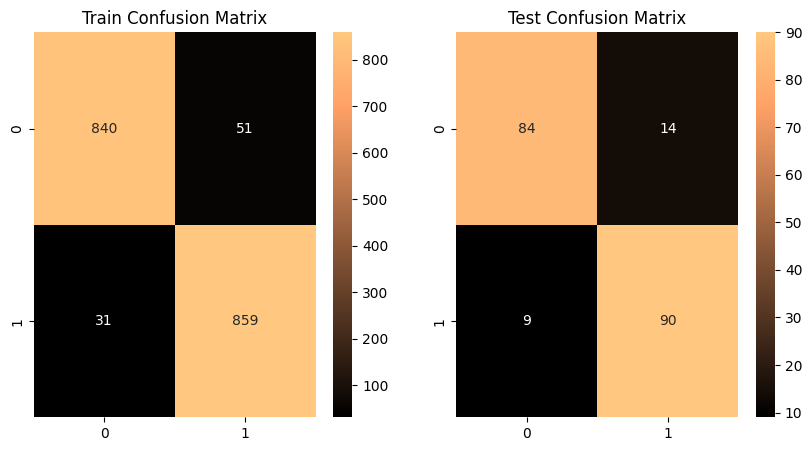

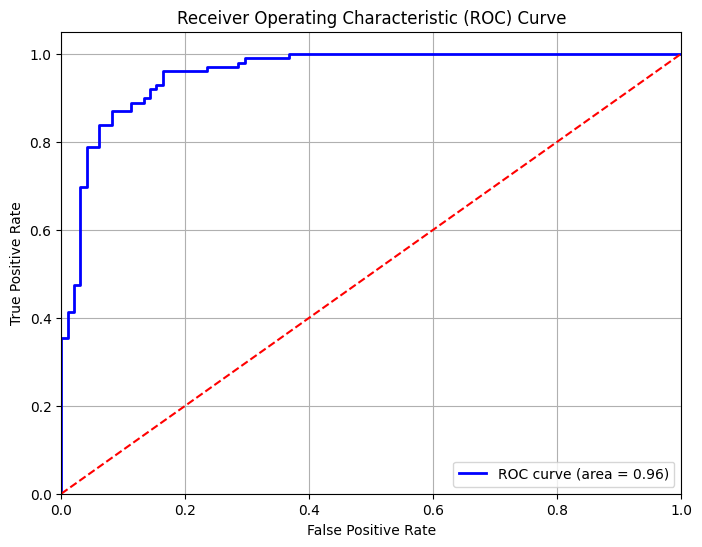

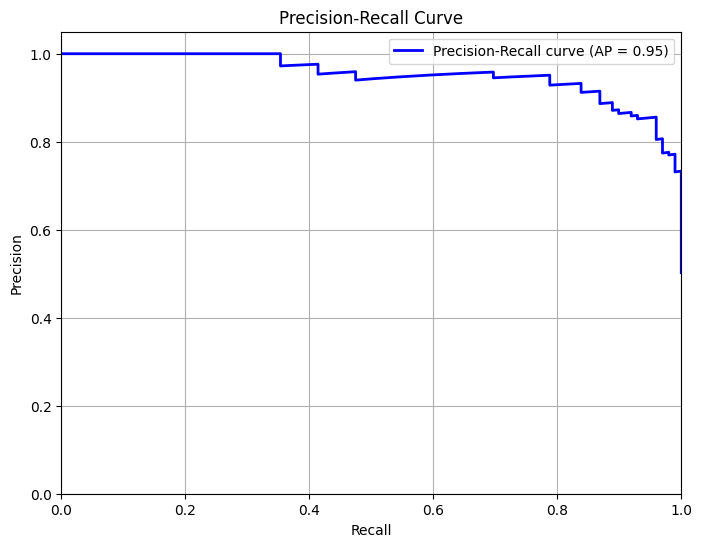

In [6]:
from sklearn.linear_model import LogisticRegression

# 1. Apply SMOTE to balance the data
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X_OS, Y_OS)

# 2. Set up Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


# Define Logistic Regression parameters for GridSearchCV
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200]
}

# Initialize GridSearchCV for Logistic Regression
grid_search = GridSearchCV(LogisticRegression(random_state=42),
                              param_grid_lr, 
                              cv=5, 
                              scoring='accuracy', 
                              n_jobs=-1)

# Fit GridSearchCV and find best model
grid_search.fit(X_res, Y_res)
best_model = grid_search.best_estimator_

# Follow the same process for cross-validation as in your RandomForest code

# Initialize lists to store scores
metrics_dict = {
    'train_acc': [], 'test_acc': [],
    'train_prec': [], 'test_prec': [],
    'train_recall': [], 'test_recall': [],
    'train_f1': [], 'test_f1': [],
    'train_mcc': [], 'test_mcc': []
}
final_train_conf_matrix, final_test_conf_matrix = None, None

# 4. Perform Stratified Cross-Validation
for fold_idx, (train_index, test_index) in enumerate(cv.split(X_res, Y_res)):
    # Split the data into training and testing sets
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    Y_train, Y_test = Y_res[train_index], Y_res[test_index]
    
    # Train the best model found by GridSearchCV
    best_model.fit(X_train, Y_train)
    
    # Predictions for training and test data
    pred_train = best_model.predict(X_train)
    pred_test = best_model.predict(X_test)
    
    # 5. Calculate performance metrics
    metrics_dict['train_acc'].append(metrics.accuracy_score(Y_train, pred_train))
    metrics_dict['test_acc'].append(metrics.accuracy_score(Y_test, pred_test))
    
    metrics_dict['train_prec'].append(metrics.precision_score(Y_train, pred_train, average="macro"))
    metrics_dict['test_prec'].append(metrics.precision_score(Y_test, pred_test, average="macro"))

    metrics_dict['train_recall'].append(metrics.recall_score(Y_train, pred_train, average="macro"))
    metrics_dict['test_recall'].append(metrics.recall_score(Y_test, pred_test, average="macro"))

    metrics_dict['train_f1'].append(metrics.f1_score(Y_train, pred_train, average="macro"))
    metrics_dict['test_f1'].append(metrics.f1_score(Y_test, pred_test, average="macro"))

    metrics_dict['train_mcc'].append(metrics.matthews_corrcoef(Y_train, pred_train))
    metrics_dict['test_mcc'].append(metrics.matthews_corrcoef(Y_test, pred_test))
    
    # Store confusion matrices from the last fold
    if fold_idx == (cv.n_splits - 1):
        final_train_conf_matrix = confusion_matrix(Y_train, pred_train)
        final_test_conf_matrix = confusion_matrix(Y_test, pred_test)

# 6. Print average performance metrics across all folds
print(f"Train Accuracy: {np.mean(metrics_dict['train_acc']):.4f}")
print(f"Test Accuracy: {np.mean(metrics_dict['test_acc']):.4f}")
print(f"Train Precision: {np.mean(metrics_dict['train_prec']):.4f}")
print(f"Test Precision: {np.mean(metrics_dict['test_prec']):.4f}")
print(f"Train Recall: {np.mean(metrics_dict['train_recall']):.4f}")
print(f"Test Recall: {np.mean(metrics_dict['test_recall']):.4f}")
print(f"Train F1-score: {np.mean(metrics_dict['train_f1']):.4f}")
print(f"Test F1-score: {np.mean(metrics_dict['test_f1']):.4f}")
print(f"Matthews correlation coefficient (Train): {np.mean(metrics_dict['train_mcc']):.4f}")
print(f"Matthews correlation coefficient (Test): {np.mean(metrics_dict['test_mcc']):.4f}")

# 7. Classification reports for the final fold
print("\nClassification Report (Train):")
print(metrics.classification_report(Y_train, pred_train))
print("\nClassification Report (Test):")
print(metrics.classification_report(Y_test, pred_test))

# 8. Plot Confusion Matrix for the final fold
plt.figure(figsize=(10, 5))

# Confusion matrix for Train data
plt.subplot(1, 2, 1)
sns.heatmap(final_train_conf_matrix, annot=True, cmap='copper', fmt="g")
plt.title('Train Confusion Matrix')

# Confusion matrix for Test data
plt.subplot(1, 2, 2)
sns.heatmap(final_test_conf_matrix, annot=True, cmap='copper', fmt="g")
plt.title('Test Confusion Matrix')

plt.show()

# 9. Compute ROC Curve and AUC
pred_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, pred_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

precision, recall, _ = precision_recall_curve(Y_test, pred_test_prob)
average_precision = average_precision_score(Y_test, pred_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend()
plt.show()



In [7]:
AA_t="C:/Users/ganes/OneDrive/Desktop/AI/Drug/S-Test-Final.xlsx"
X_t = pd.read_excel(AA_t, usecols='A:AMJ') 
Y_t=pd.read_excel(AA_t, usecols='AMK')
LGR_new = best_model.predict(X_t)
Acctrain_LGR = metrics.accuracy_score(Y_t, LGR_new)
print(Acctrain_LGR)

0.7307692307692307


In [8]:
print(LGR_new)
df_LGRt = pd.DataFrame (LGR_new)
df_LGRt.columns=["Predicted"] 
filepath = 'LGR.xlsx'
df_LGRt.to_excel(filepath, index=False)

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1]
